# Day 79
Continue analyzing the Fantasy Regular Season vs. Playoffs performances, this time by plotting a histogram of `pct_change` to see the distribution. In this case, `pct_change` is just how much better or worse a player performed in the playoffs vs the regular season.

In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('deep')

# Create database connection
conn = sqlite3.connect('../../data/db/database_test.db')

In [13]:
# Same query as Day 78
query = """
WITH reg_season_rankings_1999_2021 AS (
    SELECT
        season,
        player_name,
        position,
        avg_pts,
        avg_pts_ppr,
        DENSE_RANK() OVER(PARTITION BY season ORDER BY avg_pts DESC) AS r_pts_reg_season,
        DENSE_RANK() OVER(PARTITION BY season ORDER BY avg_pts_ppr DESC) AS r_pts_ppr_reg_season
    FROM
    (
        SELECT
            season,
            player_display_name AS player_name,
            position,
            ROUND(AVG(fantasy_points), 2) AS avg_pts,
            ROUND(AVG(fantasy_points_ppr), 2) AS avg_pts_ppr
        FROM weekly
        WHERE season < 2022
            AND week < 14
        GROUP BY season, player_display_name, position
        
    )
), reg_season_rankings_2022 AS (
    SELECT
        season,
        player_name,
        position,
        avg_pts,
        avg_pts_ppr,
        RANK() OVER(PARTITION BY season ORDER BY avg_pts DESC) AS r_pts_reg_season,
        RANK() OVER(PARTITION BY season ORDER BY avg_pts_ppr DESC) AS r_pts_ppr_reg_season
    FROM
    (
        SELECT
            season,
            player_display_name AS player_name,
            position,
            ROUND(AVG(fantasy_points), 2) AS avg_pts,
            ROUND(AVG(fantasy_points_ppr), 2) AS avg_pts_ppr
        FROM weekly
        WHERE season = 2022
            AND week < 15
            AND recent_team NOT IN ('CIN', 'BUF')
        GROUP BY season, player_display_name, position
        
    )
), fantasy_reg_season AS (
    SELECT *
    FROM reg_season_rankings_1999_2021
    UNION ALL
    SELECT *
    FROM reg_season_rankings_2022
), playoff_rankings_1999_2021 AS (
    SELECT
        season,
        player_name,
        position,
        avg_pts,
        avg_pts_ppr,
        DENSE_RANK() OVER(PARTITION BY season ORDER BY avg_pts DESC) AS r_pts_playoffs,
        DENSE_RANK() OVER(PARTITION BY season ORDER BY avg_pts_ppr DESC) AS r_pts_ppr_playoffs
    FROM
    (
        SELECT
            season,
            player_display_name AS player_name,
            position,
            ROUND(AVG(fantasy_points), 2) AS avg_pts,
            ROUND(AVG(fantasy_points_ppr), 2) AS avg_pts_ppr
        FROM weekly
        WHERE season < 2022
            AND week BETWEEN 14 AND 16
        GROUP BY season, player_display_name, position
        
    )
), playoff_rankings_2022 AS (
    SELECT
        season,
        player_name,
        position,
        avg_pts,
        avg_pts_ppr,
        RANK() OVER(PARTITION BY season ORDER BY avg_pts DESC) AS r_pts_playoffs,
        RANK() OVER(PARTITION BY season ORDER BY avg_pts_ppr DESC) AS r_pts_ppr_playoffs
    FROM
    (
        SELECT
            season,
            player_display_name AS player_name,
            position,
            ROUND(AVG(fantasy_points), 2) AS avg_pts,
            ROUND(AVG(fantasy_points_ppr), 2) AS avg_pts_ppr
        FROM weekly
        WHERE season = 2022
            AND week BETWEEN 15 AND 17
            AND recent_team NOT IN ('CIN', 'BUF')
        GROUP BY season, player_display_name, position
        
    )
), fantasy_playoffs AS (
    SELECT *
    FROM playoff_rankings_1999_2021
    UNION ALL
    SELECT *
    FROM playoff_rankings_2022
), player_season_ppr AS (
    SELECT
        reg.season,
        reg.player_name,
        reg.position,
        -- r_pts_reg_season,
        reg.avg_pts_ppr AS avg_reg_season,
        r_pts_ppr_reg_season,
        -- r_pts_playoffs,
        play.avg_pts_ppr AS avg_playoffs,
        r_pts_ppr_playoffs,
        -- (r_pts_ppr_playoffs - r_pts_ppr_reg_season) AS r_diff,
        ROUND(((play.avg_pts_ppr - reg.avg_pts_ppr)/reg.avg_pts_ppr) * 100, 2) AS pct_change
    FROM fantasy_reg_season AS reg
    INNER JOIN fantasy_playoffs AS play
        ON play.season = reg.season
        AND play.player_name = reg.player_name
        AND play.position = reg.position
    WHERE r_pts_reg_season <= 100
        -- QBs tend to add noise
        AND reg.position <> 'QB'
        -- Don't want to add injured players
        AND r_pts_ppr_playoffs < 150
    ORDER BY pct_change ASC
)
SELECT *
FROM player_season_ppr
"""

df = pd.read_sql(query, conn)
df

,season,player_name,position,avg_reg_season,r_pts_ppr_reg_season,avg_playoffs,r_pts_ppr_playoffs,pct_change
0,2000,Eric Moulds,WR,19.95,15,5.47,143,-72.58
1,2004,Terrell Owens,WR,22.12,5,6.50,146,-70.61
2,2002,Marshall Faulk,RB,24.73,3,7.47,134,-69.79
3,2006,Steve Smith,WR,20.83,5,7.27,133,-65.10
4,2000,Michael Pittman,RB,16.79,33,6.17,131,-63.25
...,...,...,...,...,...,...,...,...
1271,2021,Damien Harris,RB,12.23,99,28.30,5,131.40
1272,2008,Pierre Thomas,RB,10.65,99,24.93,3,134.08
1273,2004,Drew Bennett,WR,13.75,59,32.97,1,139.78
1274,2020,Myles Gaskin,RB,14.08,77,33.90,1,140.77


In [15]:
df.describe().round(2)

,season,avg_reg_season,r_pts_ppr_reg_season,avg_playoffs,r_pts_ppr_playoffs,pct_change
count,1276.00,1276.00,1276.00,1276.00,1276.00,1276.00
mean,2010.02,15.80,46.94,15.39,58.68,-1.01
std,6.81,3.45,30.11,5.63,39.74,33.90
min,1999.00,8.74,1.00,5.47,1.00,-72.58
25%,2004.00,13.42,22.75,11.17,24.00,-25.12
50%,2010.00,15.26,44.00,14.37,53.00,-6.52
75%,2016.00,17.58,66.00,18.60,90.00,17.98
max,2022.00,32.77,149.00,42.45,149.00,182.71


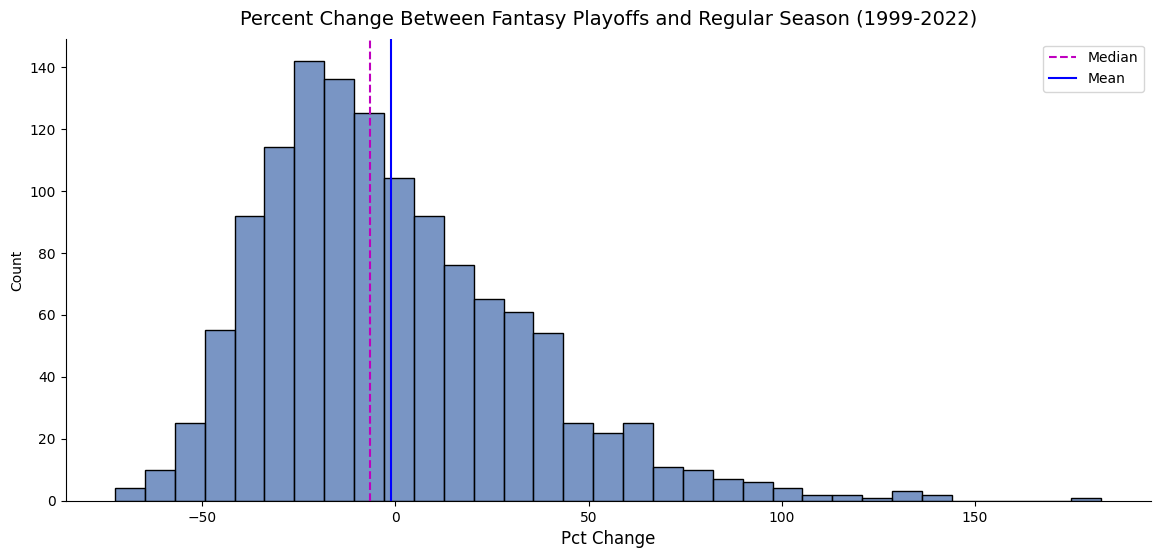

In [12]:
# Change plot size
fig = plt.figure(figsize = (14,6))
ax = fig.add_subplot()

g = sns.histplot(
    x='pct_change',
    data=df,
    fill=True,
    ax=ax
)

# Add vertical lines
ax.axvline(x=df['pct_change'].median(), color='m', label='Median', linestyle='--', linewidth=1.5)
ax.axvline(x=df['pct_change'].mean(), color='b', label='Mean', linestyle='-', linewidth=1.5)

# Add axis labels and title
g.set_xlabel("Pct Change", size=12)
g.set_title("Percent Change Between Fantasy Playoffs and Regular Season (1999-2022)", size=14, pad=10)

# Customize Plot
plt.legend()
# plt.grid(axis='y')
ax.set_axisbelow(True)

sns.despine()

plt.show()

Interestingly enough, the average of `pct_change` is approximately zero (actually -1%) with a standard deviation of 34%. So an approx. normal distribution. Just based on the shape being right-skewed it seems that most players actually do slightly worse, with the mode around -25%. The median is -6.5% so 50% of players are at least -6.5% worse in the playoffs (on average).  


So practically-speaking, what does this mean? You start your studs regardless since you have a basically 50% change of them performing just slightly worse. 6% less than the regular season average is not bad for a player who is already doing well.  

I think the next step is to see if I can drill the analysis down further on the players who did do well. Are there any characteristics that may predict if a player might explode in the playoffs?